# TF txn burst initiations per hour (k_on_TF)

In [ ]:
#The code in this notebook is adapted from https://github.com/sandberg-lab/txburst/blob/master/Figure%201e%2C%201f.ipynb
#The files used below are available at that Github repository. 
#The file mmc1.xls below, for a list of mouse TFs, comes from the supplementary data from https://doi.org/10.1016/j.cell.2010.01.044
#You can also find those files in https://drive.google.com/open?id=1unl5WrqPxQcIES4FplkfHaj-I7X3I_Qs and update your file paths to get the output of this code yourself

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing data
DR_ES = pd.read_csv('/content/drive/My Drive/Colab Notebooks/slam_seq.csv', sep=';') #update this file path accordingly

cast = pd.read_pickle('/content/drive/My Drive/Colab Notebooks/SS3_cast_UMIs_mESC_ML.pkl') #update this file path accordingly

cast = cast[cast[1]][0]

cast = cast[~cast.index.duplicated(keep='first')]

DR_ES.index = DR_ES['Name']

DR_ES = DR_ES[~DR_ES.index.duplicated(keep='first')]

DR_ES = DR_ES.dropna(how='any')

DR_ES['decay'] = np.log(2)/DR_ES['Half-life (h)']

bf = pd.Series([gene[0] for gene in cast], index=cast.index)
DR_ES_scRNA = DR_ES.reindex(cast.index)

decay_ES = DR_ES_scRNA['decay']
decay_ES = decay_ES.replace([np.inf, 0], np.nan).dropna()
decay_ES = decay_ES[~decay_ES.index.duplicated(keep='first')]
decay_ES = decay_ES[decay_ES > 0]
decay_ES = decay_ES.dropna()

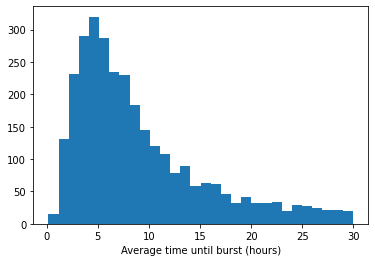

Text(0.5, 0, 'Average time until burst (hours)')

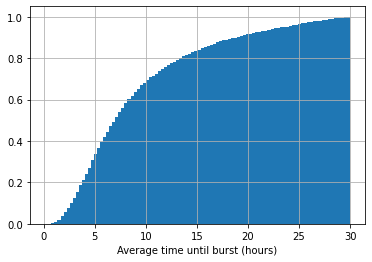

In [ ]:
bf_absolute = np.log10((bf*decay_ES).dropna())

#Histogram of time until burst (hours) – basically figure 1f of Larsson et al. 
plt.hist(1/10**bf_absolute[1/10**bf_absolute < 30], bins=30)
plt.xlabel('Average time until burst (hours)')
plt.show()

#Cumulative distribution of time until burst (hours)
ser = 1/10**bf_absolute[1/10**bf_absolute < 30]
ser.hist(cumulative=True, density=1, bins=100)
plt.xlabel('Average time until burst (hours)')

In [ ]:
# Descriptive statistics for txn burst initiations per hour
txn_burst_initiations_per_hour = 10**bf_absolute
print("1st quantile:", np.quantile(txn_burst_initiations_per_hour, 0.25))
print("Median:", np.quantile(txn_burst_initiations_per_hour, 0.5))
print("3rd quantile:", np.quantile(txn_burst_initiations_per_hour, 0.75))

print("Mean:", np.mean(txn_burst_initiations_per_hour))
print("std:", np.std(txn_burst_initiations_per_hour))

1st quantile: 0.06434062427279505
Median: 0.1258904136120143
3rd quantile: 0.21181471003547875
Mean: 0.16401146969371794
std: 0.18208294222285767


## Target txn burst initiations per hour (k_on_target)


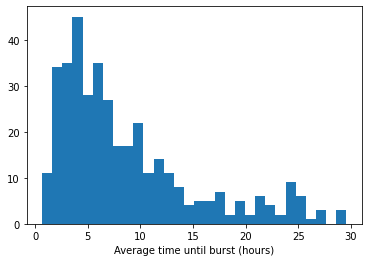

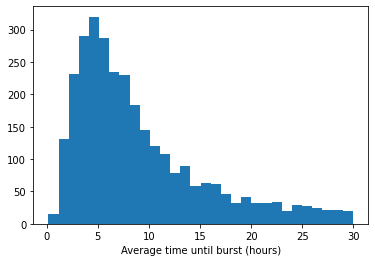

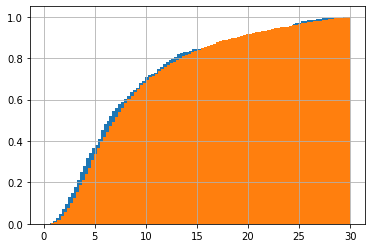

In [ ]:
#Same plots but separating for non TF and TF genes
#import list of TFs
file = r'/content/drive/My Drive/Colab Notebooks/mmc1.xls' #Update this filepath accordingly
tf_list = pd.read_excel(file)
tf_list = tf_list['Symbol (Mouse)']
tf_list = tf_list.to_frame()
tf_list = tf_list.rename(columns={"Symbol (Mouse)": "gene_symbol"})

bf_absolute = np.log10((bf*decay_ES).dropna())

#What follows has probably some unnecesary data processing steps, but it was the only way I was able to get the pd.merge function running
bf_absolute = bf_absolute.to_frame()
bf_absolute.index.name = 'gene_symbol'
bf_absolute.reset_index(inplace=True)
bf_absolute_tf = pd.merge(bf_absolute, tf_list, how='inner')

bf_absolute_non_tf = pd.merge(bf_absolute, tf_list, how='outer')

bf_absolute_tf = bf_absolute_tf.set_index('gene_symbol') 
bf_absolute_tf.index.names = [None] 

bf_absolute_non_tf = bf_absolute_non_tf.set_index('gene_symbol') 
bf_absolute_non_tf.index.names = [None] 

bf_absolute_tf = bf_absolute_tf[0].astype('float')

bf_absolute_non_tf = bf_absolute_non_tf[0].astype('float')

#Histogram time until burst TF
plt.hist(1/10**bf_absolute_tf[1/10**bf_absolute_tf < 30], bins=30)
plt.xlabel('Average time until burst (hours)')
plt.show()

#Histogram time until burst non_TF
plt.hist(1/10**bf_absolute_non_tf[1/10**bf_absolute_non_tf < 30], bins=30)
plt.xlabel('Average time until burst (hours)')
plt.show()

#Cumulative distribution TF
ser = 1/10**bf_absolute_tf[1/10**bf_absolute_tf < 30]
ser.hist(cumulative=True, density=1, bins=100)

#Cumulative distribution non_TF
ser = 1/10**bf_absolute_non_tf[1/10**bf_absolute_non_tf < 30]
ser.hist(cumulative=True, density=1, bins=100)

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


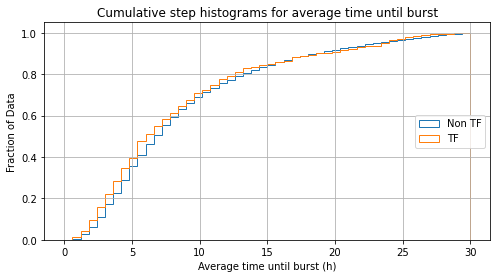

In [ ]:
#This is just to make a different type of cumulative step histogram, but it is the same data

import matplotlib.pyplot as plt

n_bins = 50
fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist((1/10**bf_absolute_non_tf), n_bins, density=True, histtype='step',
                           cumulative=True, label='Non TF', range=(0, 30))


# Overlay the second cumulative histogram
ax.hist((1/10**bf_absolute_tf), bins, density=True, histtype='step', cumulative=True,
        label='TF')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms for average time until burst')
ax.set_xlabel('Average time until burst (h)')
ax.set_ylabel('Fraction of Data')

plt.show()

# TF txn burst ends per hour (k_off_TF)


In [ ]:
#First, some data preprocessing (data is in an excel file and the k_off is buried between other constants)

import re as re

#Import the table with k_off values (one of the supplementary files in Larsson et al. 2019)
kinetic_constants = pd.read_excel (r'/content/drive/My Drive/Colab Notebooks/41586_2018_836_MOESM3_ESM.xlsx', 'CAST')
k_off = kinetic_constants['Maximum likelihood (kon, koff, ksyn)']
k_off = k_off.to_string()

# extracting k_off values
#Firsrt, get only the column with the kon, koff, ksyn values
k_off_pattern="(?<=\[).*?(?=\])"
k_off = re.findall(k_off_pattern, k_off)

#Then, remove the leading space
new_k_off = []
for i in k_off:
    new_k_off.append(i.strip())

#Next, convert double spaces into single spaces
new_k_off_2 = []
for i in new_k_off:
    new_k_off_2.append(' '.join(i.split()))

#Next, get the numbers between two spaces
final_k_off = []
for i in new_k_off_2:
  final_k_off.append(float(i.split()[1]))

#Convert into Pandas series and multiply by degradation rate to get k_off in absolute time (rationale explained in the Methods section of Larsson et al. 2019)
#I use  0.161 as the degradation rate corresponding to the median cell-cycle normalized half-life of 4.3h  (see the previous section in this notebook "TF txn burst initiations per hour")
final_k_off = pd.Series(final_k_off).astype(float)
k_off_absolute = final_k_off * 0.161 

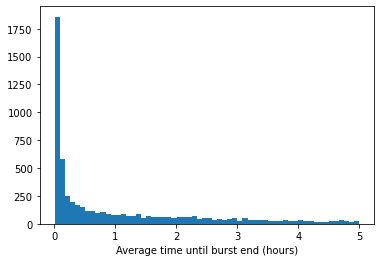

Text(0.5, 0, 'Average time until burst end (hours)')

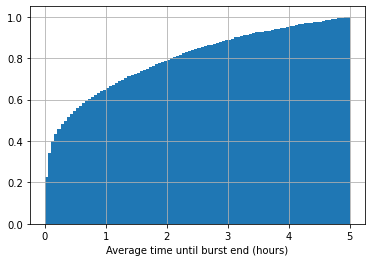

In [ ]:
#Histogram of time until burst end (hours)
plt.hist(1/k_off_absolute[1/k_off_absolute < 5], bins=60)
plt.xlabel('Average time until burst end (hours)')
plt.show()

#Cumulative distribution of time until burst end (hours)
ser = 1/k_off_absolute[1/k_off_absolute < 5]
ser.hist(cumulative=True, density=1, bins=100)
plt.xlabel('Average time until burst end (hours)')

In [ ]:
# Descriptive statistics for txn burst ends per hour (k_off_tf)
print("1st quantile:", np.quantile(k_off_absolute, 0.25))
print("Median:", np.quantile(k_off_absolute, 0.5))
print("3rd quantile:", np.quantile(k_off_absolute, 0.75))

print("Mean:", np.mean(k_off_absolute))
print("std:", np.std(k_off_absolute))

1st quantile: 0.337364076245
Median: 1.4573356188300002
3rd quantile: 12.77170993329
Mean: 10.119500534799117
std: 19.02066494687913


## Target txn burst ends per hour (k_off_target)

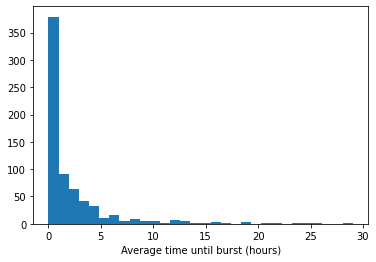

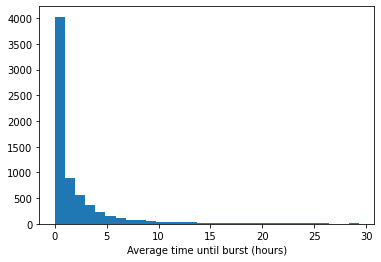

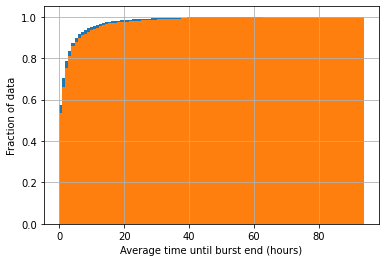

In [ ]:
#Same plots but separating for non TF and TF genes
#import list of TFs
file = r'/content/drive/My Drive/Colab Notebooks/mmc1.xls' #Update this filepath accordingly
tf_list = pd.read_excel(file)
tf_list = tf_list['Symbol (Mouse)']
tf_list = tf_list.to_frame()
tf_list = tf_list.rename(columns={"Symbol (Mouse)": "Gene"})

#Put gene names in k_off_absolute
k_off_absolute = final_k_off * 0.2
k_off_absolute = k_off_absolute.to_frame()
k_off_absolute.index = [kinetic_constants['Gene']] 
k_off_absolute.index.name = 'gene_symbol'
k_off_absolute.reset_index(inplace=True)

#Find TFs in k_off_absolute
k_off_absolute_tf = pd.merge(k_off_absolute, tf_list, how='inner')

#Find non TFs in k_off_absolute
k_off_absolute_non_tf = pd.merge(k_off_absolute, tf_list, how='outer')

#Variable processing to show the graphs
k_off_absolute_tf = k_off_absolute_tf[0].astype('float')
k_off_absolute_non_tf = k_off_absolute_non_tf[0].astype('float')

#Histogram time until burst TF
plt.hist(1/k_off_absolute_tf[1/k_off_absolute_tf < 30], bins=30)
plt.xlabel('Average time until burst (hours)')
plt.show()

#Histogram time until burst non_TF
plt.hist(1/k_off_absolute_non_tf[1/k_off_absolute_non_tf < 30], bins=30)
plt.xlabel('Average time until burst (hours)')
plt.show()

#Cumulative distribution non_TF
ser = 1/k_off_absolute_non_tf[1/k_off_absolute_non_tf < 100]
ser.hist(cumulative=True, density=1, bins=100)
plt.xlabel('Average time until burst end (hours)')
plt.ylabel('Fraction of data')

#Cumulative distribution TF
ser = 1/k_off_absolute_tf[1/k_off_absolute_tf < 100]
ser.hist(cumulative=True, density=1, bins=100)

# Burst size

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
ML_concat = pd.read_pickle('/content/drive/MyDrive/Bursting constants colab notebooks and raw data/SS3_cast_UMIs_concat_ML.pkl') #Update file path accordingly
ML_concat = ML_concat[ML_concat[1]][0]
cast_bs_UMI = pd.Series([gene[2]/gene[1] for gene in ML_concat], index=ML_concat.index)

In [ ]:
cast_bs_UMI < 0
cast_bs_UMI < 0

0610007P14Rik    False
0610009B22Rik    False
0610009O20Rik    False
0610010F05Rik    False
0610012G03Rik    False
                 ...  
Zxdb             False
Zxdc             False
Zyg11b           False
Zyx              False
l7Rn6            False
Length: 7186, dtype: bool

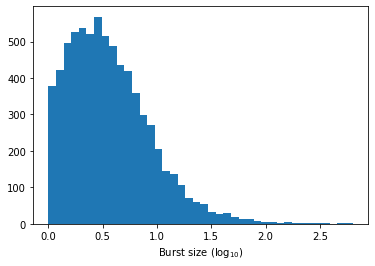

In [ ]:

plt.hist(np.log10(cast_bs_UMI), bins=40)
plt.xlabel(r'Burst size (log$_{10}$)')
plt.show()

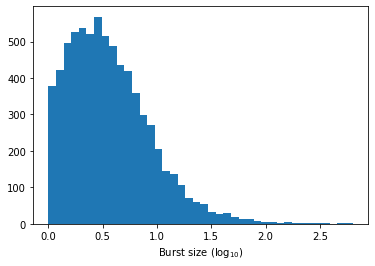

In [ ]:
#Figure 1d from Larsson et al. 
plt.hist(np.log10(cast_bs_UMI), bins=40)
plt.xlabel(r'Burst size (log$_{10}$)')
plt.show()

In [ ]:
# Descriptive statistics for mRNA burst size (mRNA transcripts initiated per hour during a burst)
print("1st quantile:", np.quantile(cast_bs_UMI, 0.25))
print("Median:", np.quantile(cast_bs_UMI, 0.5))
print("3rd quantile:", np.quantile(cast_bs_UMI, 0.75))

print("Mean:", np.mean(cast_bs_UMI))
print("std:", np.std(cast_bs_UMI))

1st quantile: 1.8898704170932552
Median: 3.2250006217091665
3rd quantile: 6.115443128200602
Mean: 6.633886854086943
std: 19.282030317005496


In [ ]:
#Again I am going to check if there are burst size differences in TF and non TF
cast_bs_UMI = pd.Series([gene[2]/gene[1] for gene in ML_concat], index=ML_concat.index)

#Get the TF list again
file = r'/content/drive/My Drive/Colab Notebooks/mmc1.xls' #Update this filepath accordingly
tf_list = pd.read_excel(file)
tf_list = tf_list['Symbol (Mouse)']
tf_list = tf_list.to_frame()
tf_list = tf_list.rename(columns={"Symbol (Mouse)": "gene_symbol"})

#Again, data pre-processing to be able to use the pd.merge function
cast_bs_UMI = cast_bs_UMI.to_frame()
cast_bs_UMI.index.name = 'gene_symbol'
cast_bs_UMI.reset_index(inplace=True)

bs_tf = pd.merge(cast_bs_UMI, tf_list, how='inner')
bs_non_tf = pd.merge(cast_bs_UMI, tf_list, how='outer')

bs_tf = bs_tf.set_index('gene_symbol') 
bs_tf.index.names = [None] 
bs_non_tf = bs_non_tf.set_index('gene_symbol') 
bs_non_tf.index.names = [None] 

bs_tf = bs_tf[0].astype('float')
bs_non_tf = bs_non_tf[0].astype('float')

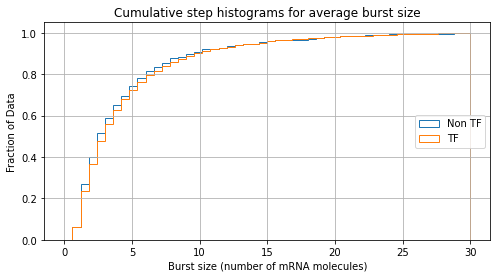

In [ ]:
#Now time to do the graphs

import matplotlib.pyplot as plt

n_bins = 50
fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(bs_tf, n_bins, density=True, histtype='step',
                           cumulative=True, label='Non TF', range=(0, 30))
# Overlay the second cumultative histogram
ax.hist(bs_non_tf, bins, density=True, histtype='step', cumulative=True,
        label='TF')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms for average burst size')
ax.set_xlabel('Burst size (number of mRNA molecules)')
ax.set_ylabel('Fraction of Data')

plt.show()

# Protein production rate (proteins per hour per mature mRNA)

In [ ]:
#The data comes from Schwanhäuser et al. Nature 2011 (supplementary table 41586_2011_BFnature10098_MOESM304_ESM.xls)
#Importing the data
file = r'/content/drive/My Drive/Colab Notebooks/41586_2011_BFnature10098_MOESM304_ESM.xls' #Update this filepath accordingly
nature_2011 = pd.read_excel(file)
translation_rate_constant = nature_2011['translation rate constant (ksp) average [molecules/(mRNA*h)]']
# Drop NA values
translation_rate_constant = translation_rate_constant.dropna(how='any')

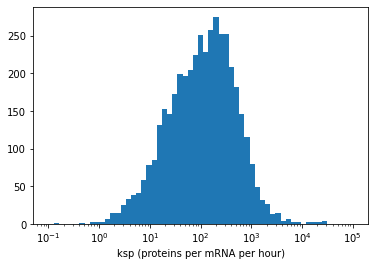

In [ ]:
#Check if I recapitulate figure 3c from Schwanhäuser et al. Nature 2011
import matplotlib.pyplot as plt
import numpy as np
bins = 10 ** np.linspace(np.log10(0.1), np.log10(100000), 60) # to set log axis
plt.xscale('log')
plt.hist(translation_rate_constant,bins=bins) 
plt.xlabel(r'ksp (proteins per mRNA per hour)')
plt.show()

In [ ]:
# Descriptive statistics for protein production rate
print("1st quantile:", np.quantile(translation_rate_constant, 0.25))
print("Median:", np.quantile(translation_rate_constant, 0.5))
print("3rd quantile:", np.quantile(translation_rate_constant, 0.75))

print("Mean:", np.mean(translation_rate_constant))
print("std:", np.std(translation_rate_constant))

1st quantile: 37.01
Median: 116.84
3rd quantile: 309.28
Mean: 409.2224534965855
std: 4275.590927685393


# mRNA half life from degradation (hours)

In [ ]:
import math as math
# Descriptive statistics for mRNA decay in mESC cells (from Larsson et al. slam_seq.csv, which in turn it took it from Herzog et al. 2017 – SLAM-seq paper–)
mRNA_half_life = DR_ES['Half-life (h)']
print("1st quantile:", np.quantile(mRNA_half_life, 0.25))
print("Median:", np.quantile(mRNA_half_life, 0.5))
print("3rd quantile:", np.quantile(mRNA_half_life, 0.75))

print("Mean:", np.mean(mRNA_half_life))
print("std:", np.std(mRNA_half_life))

1st quantile: 2.666909792
Median: 3.736625762
3rd quantile: 5.162719028
Mean: 4.281614662864468
std: 2.466505809045498


Next I am also providing descriptive statistics from the Schwanhäuser et al. Nature 2011 –mouse fibroblasts–):

In [ ]:
#Importing the data
file = r'/content/drive/My Drive/Colab Notebooks/41586_2011_BFnature10098_MOESM304_ESM.xls' #Update this filepath accordingly
nature_2011 = pd.read_excel(file)
mRNA_half_life_nature_2011 = nature_2011['mRNA half-life average [h]']
# Drop NA values
mRNA_half_life_nature_2011 = mRNA_half_life_nature_2011.dropna(how='any')

In [ ]:
# Descriptive statistics for mRNA half-life for mouse fibroblasts
print("1st quantile:", np.quantile(mRNA_half_life_nature_2011, 0.25))
print("Median:", np.quantile(mRNA_half_life_nature_2011, 0.5))
print("3rd quantile:", np.quantile(mRNA_half_life_nature_2011, 0.75))

print("Mean:", np.mean(mRNA_half_life_nature_2011))
print("std:", np.std(mRNA_half_life_nature_2011))

1st quantile: 7.21
Median: 9.925
3rd quantile: 13.21
Mean: 10.751361099184217
std: 4.94627050630685


I will also add the data from the TimeLapse-seq paper (Schofield et al. 2018) for K562:

In [ ]:
#Importing the data
file = r'/content/drive/My Drive/Colab Notebooks/41592_2018_BFnmeth4582_MOESM5_ESM.xlsx' #Update this filepath accordingly
K562_timelapse_2018 = pd.read_excel(file, sheet_name=0)
k562_mRNA_half_life_timelapse_2018 = K562_timelapse_2018['mean_half_life']
k562_mRNA_half_life_timelapse_2018 = k562_mRNA_half_life_timelapse_2018.dropna(how='any')

In [ ]:
# Descriptive statistics for mRNA half-life for K562 with timelapse-seq
print("1st quantile:", np.quantile(k562_mRNA_half_life_timelapse_2018, 0.25))
print("Median:", np.quantile(k562_mRNA_half_life_timelapse_2018, 0.5))
print("3rd quantile:", np.quantile(k562_mRNA_half_life_timelapse_2018, 0.75))

print("Mean:", np.mean(k562_mRNA_half_life_timelapse_2018))
print("std:", np.std(k562_mRNA_half_life_timelapse_2018))

1st quantile: 0.78873801302476
Median: 1.5608045165747
3rd quantile: 3.0917264550895602
Mean: 2.3389303299622677
std: 2.226759790901687


I will also add the data from the TimeLapse-seq paper (Schofield et al. 2018) for mouse MEF:

In [ ]:
#Importing the data
file = r'/content/drive/My Drive/Colab Notebooks/41592_2018_BFnmeth4582_MOESM5_ESM.xlsx' #Update this filepath accordingly
MEF_timelapse_2018 = pd.read_excel(file, sheet_name=1)
MEF_mRNA_half_life_timelapse_2018 = MEF_timelapse_2018['mean_half_life']
MEF_mRNA_half_life_timelapse_2018 = MEF_mRNA_half_life_timelapse_2018.dropna(how='any')

In [ ]:
# Descriptive statistics for mRNA half-life for K562 with timelapse-seq
print("1st quantile:", np.quantile(MEF_mRNA_half_life_timelapse_2018, 0.25))
print("Median:", np.quantile(MEF_mRNA_half_life_timelapse_2018, 0.5))
print("3rd quantile:", np.quantile(MEF_mRNA_half_life_timelapse_2018, 0.75))

print("Mean:", np.mean(MEF_mRNA_half_life_timelapse_2018))
print("std:", np.std(MEF_mRNA_half_life_timelapse_2018))

1st quantile: 1.7890616043808873
Median: 2.73016475130761
3rd quantile: 4.305357640063735
Mean: 3.55948321756278
std: 2.847915533456872


Let's see if there are differences by TFs:

In [ ]:
#Get the TF list 
file = r'/content/drive/My Drive/Colab Notebooks/mmc1.xls' #Update this filepath accordingly
tf_list = pd.read_excel(file)
tf_list = tf_list['Symbol (Mouse)']
tf_list = tf_list.to_frame()
tf_list = tf_list.rename(columns={"Symbol (Mouse)": "transcript"})

#data pre-processing to be able to use the pd.merge function
MEF_mRNA_half_life_timelapse_2018 = MEF_timelapse_2018[['transcript','mean_half_life']]
MEF_mRNA_half_life_timelapse_2018_tf = pd.merge(MEF_mRNA_half_life_timelapse_2018, tf_list, how='inner')
MEF_mRNA_half_life_timelapse_2018_non_tf = pd.merge(MEF_mRNA_half_life_timelapse_2018, tf_list, how='outer')

MEF_mRNA_half_life_timelapse_2018_tf = MEF_mRNA_half_life_timelapse_2018_tf.set_index('transcript') 
MEF_mRNA_half_life_timelapse_2018_tf.index.names = [None] 

MEF_mRNA_half_life_timelapse_2018_non_tf = MEF_mRNA_half_life_timelapse_2018_non_tf.set_index('transcript') 
MEF_mRNA_half_life_timelapse_2018_non_tf.index.names = [None] 

MEF_mRNA_half_life_timelapse_2018_tf = MEF_mRNA_half_life_timelapse_2018_tf.T.squeeze()
MEF_mRNA_half_life_timelapse_2018_non_tf = MEF_mRNA_half_life_timelapse_2018_non_tf.T.squeeze()

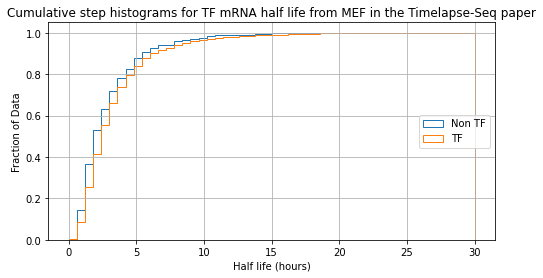

In [ ]:
#Now time to do the graphs

import matplotlib.pyplot as plt

n_bins = 50
fig, ax = plt.subplots(figsize=(8, 4))

# plot the cumulative histogram
n, bins, patches = ax.hist(MEF_mRNA_half_life_timelapse_2018_tf, n_bins, density=True, histtype='step',
                           cumulative=True, label='Non TF', range=(0, 30))

# Overlay the second cumultative histogram
ax.hist(MEF_mRNA_half_life_timelapse_2018_non_tf, bins, density=True, histtype='step', cumulative=True,
        label='TF')

# tidy up the figure
ax.grid(True)
ax.legend(loc='right')
ax.set_title('Cumulative step histograms for TF mRNA half life from MEF in the Timelapse-Seq paper')
ax.set_xlabel('Half life (hours)')
ax.set_ylabel('Fraction of Data')

plt.show()

# Protein half-life (hours)

In [ ]:
#The data comes from Schwanhäuser et al. Nature 2011 (supplementary table 41586_2011_BFnature10098_MOESM304_ESM.xls)

#Importing the data
file = r'/content/drive/My Drive/Colab Notebooks/41586_2011_BFnature10098_MOESM304_ESM.xls' #Update this filepath accordingly
nature_2011 = pd.read_excel(file)
protein_half_life = nature_2011['Protein half-life average [h]']
print(protein_half_life)

0        94.71
1       104.65
2        61.92
3        93.48
4        79.67
         ...  
5023     15.93
5024     10.33
5025     40.94
5026     29.93
5027     13.49
Name: Protein half-life average [h], Length: 5028, dtype: float64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Descriptive statistics for protein half-life
print("1st quantile:", np.quantile(protein_half_life, 0.25))
print("Median:", np.quantile(protein_half_life, 0.5))
print("3rd quantile:", np.quantile(protein_half_life, 0.75))

print("Mean:", np.mean(protein_half_life))
print("std:", np.std(protein_half_life))

1st quantile: 24.2775
Median: 47.905
3rd quantile: 87.98
Mean: 82.25059864757347
std: 187.25912743897945
